In [23]:
##Where to use number of ensembles and how?
##model data doesnt depend on start date and end date
import xarray as xr
import numpy as np
import pandas as pd
import datetime
import cftime
import math
from datetime import date, timedelta, datetime

import yaml
import glob
import gc

import sys
sys.path.insert(0, '../../Utils')
from pathlib import Path
#from obs_utils import *
from fcst_utils import *
from t2m_utils import *

In [24]:
##Obs data of u200, u850, olr
file_obs_u200 = '../obs_data/modified_u200.nc'
file_obs_u850 = '../obs_data/modified_u850.nc'
file_obs_olr = '../obs_data/modified_olr.nc'

ds_obs_u200 = xr.open_dataset(file_obs_u200)
ds_obs_u850 = xr.open_dataset(file_obs_u850)
ds_obs_olr = xr.open_dataset(file_obs_olr)

#selecting data from 120 days before start date to end date given by user
start_date = '2011-04-01'
#121 to add an extra day to make up for leap year date as well
start_date_120 = (datetime.strptime(start_date, '%Y-%m-%d') - timedelta(days=121)).strftime('%Y-%m-%d')
end_date = '2018-05-10'
initial_days=[1,]

ds_obs_u200_d = ds_obs_u200['var'].sel(time=slice(start_date_120,end_date ))


ds_obs_u850_d = ds_obs_u850['var'].sel(time=slice(start_date_120,end_date ))


ds_obs_olr_d = ds_obs_olr['var'].sel(time=slice(start_date_120,end_date ))


# make sure obs is organized lon and time to be consistent with regridded data
ds_obs_u200_subset=ds_obs_u200_d.transpose('longitude','time')
ds_obs_u850_subset = ds_obs_u850_d.transpose('longitude','time')
ds_obs_olr_subset = ds_obs_olr_d.transpose('longitude','time')



In [25]:
##EOF analysis
f=open('ceof.ev',mode='r')
array=np.fromfile(f,dtype=np.float32,count=4*144*75)
data=np.reshape(array,(25,3,144))
modes=2
eof_olr=-data[:modes,0,:]
eof_u850=-data[:modes,1,:]
eof_u200=-data[:modes,2,:]

# Define the longitude values
longitude_values = np.arange(0, 2.5 * 144, 2.5)  # Example, replace it with your actual longitude values
eof_olr = xr.DataArray(eof_olr, dims=('mode', 'longitude'), coords={'mode': [0, 1], 'longitude': longitude_values})
eof_u850 = xr.DataArray(eof_u850, dims=('mode', 'longitude'), coords={'mode': [0, 1], 'longitude': longitude_values})
eof_u200 = xr.DataArray(eof_u200, dims=('mode', 'longitude'), coords={'mode': [0, 1], 'longitude': longitude_values})

def remove_120days_seasonalvar_obs(obs,std):
    avg = obs.rolling(time=120, center=False).mean()
    #print(sum(obs.values[:,:120])/120)
    obs=obs - avg
    return obs/std


In [26]:
observation_u200_120_nor = remove_120days_seasonalvar_obs(ds_obs_u200_subset,5.24)
observation_u850_120_nor = remove_120days_seasonalvar_obs(ds_obs_u850_subset,1.70)
observation_olr_120_nor = remove_120days_seasonalvar_obs(ds_obs_olr_subset,14.72)

olr_obs = observation_olr_120_nor.dropna('time') #longitude, time
u200_obs = observation_u200_120_nor.dropna('time')
u850_obs = observation_u850_120_nor.dropna('time')


olrt_dot1_obs= xr.dot(olr_obs[:,:],eof_olr[0,:],dims='longitude')
olrt_dot2_obs = xr.dot(olr_obs[:,:],eof_olr[1,:],dims='longitude')

u200t_dot1_obs = xr.dot(u200_obs[:,:],eof_u200[0,:],dims='longitude')
u200t_dot2_obs = xr.dot(u200_obs[:,:],eof_u200[1,:],dims='longitude')

u850t_dot1_obs = xr.dot(u850_obs[:,:],eof_u850[0,:],dims='longitude')
u850t_dot2_obs = xr.dot(u850_obs[:,:],eof_u850[1,:],dims='longitude')
        
innerdot1 = (olrt_dot1_obs + u200t_dot1_obs + u850t_dot1_obs) 
innerdot2  = (olrt_dot2_obs + u200t_dot2_obs + u850t_dot2_obs) 
pc1 = innerdot1 / 12.0  #obs std
pc2 = innerdot2 / 12.0  #obs std
pc1_obs=pc1.dropna('time')
pc2_obs=pc2.dropna('time')  

In [30]:
##Model data processing
def mean_120(model):
    return model.rolling(time=120, center=False).mean().dropna("time")

def is_month_in_ndjfm(date):
    month = date.month
    if month in [11, 12, 1, 2, 3]:
        return True
    else:
        return False
    

def remove_120days_seasonalvar(exp_start_dates,model_data,obs,std):
    
    model_data_120remlis=[]
    for n,i in enumerate(exp_start_dates):
        days_start=n*35
        if is_month_in_ndjfm(i):
            
            #Start date of the most recent 120 days of experiment i
            start_date_119_obs = i - timedelta(days=119)
            end_date_119 = i - timedelta(days=1)
            
            #cases when start or end date fall on leap dates
            if end_date_119.month == 2 and end_date_119.day == 29:
                end_date_119=end_date_119 - timedelta(days=1)
                start_date_119_obs = start_date_119_obs - timedelta(days=1)

            elif start_date_119_obs.month == 2 and start_date_119_obs.day == 29:
                start_date_119_obs = start_date_119_obs - timedelta(days=1)

            start_date_119_obs = (start_date_119_obs).strftime('%Y-%m-%d')
            end_date_119 = (end_date_119).strftime('%Y-%m-%d')

            #selecting obs data from start_date_120_obs to end_date_i
            obs_data = obs.sel(time=slice(start_date_119_obs,end_date_119))

            #if there is a day less, it means the date range includes a leap date
            if len(obs_data.time) == 118:
                start_date_119_obs = (datetime.strptime(start_date_119_obs, '%Y-%m-%d') - timedelta(days=1)).strftime('%Y-%m-%d')
                obs_data = obs.sel(time=slice(start_date_119_obs,end_date_119))
            
            ##model data selection
             #n = number of experiments 
             #days_start is the index of the experiment
             #using integer-based indexing because of non-unique labels in days dimension
            model = model_data.isel(time=slice(days_start,days_start+35))

            ##Concatenation of model and obs using time dimension
            concatenated_data =xr.concat([obs_data, model], dim='time')
            avg=mean_120(concatenated_data)
            avg=avg.isel(time = slice(-35,None))
            avg = avg.transpose('time','longitude')
            
            ##resetting time dimension back to 1-35 days

            model_120daysrem = xr.DataArray((model[:]-avg[:]).data, dims=('time',  'longitude'), coords={'time': model.time[:35], 'longitude': model.longitude})
            #model_data[n*35:n*35+35,:]= model_120daysrem[:] 
            
            ##program 2 normalization by observed std
            model_data_120rem = model_120daysrem[:]/std
            model_data_120remlis.append(model_data_120rem)
        
    return model_data_120remlis

In [31]:
def generate_start_dates(initial_date,start_date,end_date):
    date_range= pd.date_range(start=start_date, end=end_date, freq='MS')
    dates=[date for date in date_range if date.day == initial_date and date >= pd.to_datetime(start_date)]
    return dates

def sel_35(obs,i):
    i_35 = i+timedelta(34)
    i = (i).strftime('%Y-%m-%d')
    i_35 = (i_35).strftime('%Y-%m-%d')
    u200obs = obs.sel(time=slice(i,i_35))
    if len(u200obs.time) == 34: #the date range includes a leap day
        i_35=datetime.strptime(i_35, '%Y-%m-%d')+ timedelta(1)
        i_35 = (i_35).strftime('%Y-%m-%d')
        u200obs = obs.sel(time=slice(i,i_35))
    return u200obs.transpose('time','longitude')
        
def slice_avg(ds):
    ds_selected = ds.sel(latitude=slice(-15, 15))
    ds_avg_latitude = ds_selected.mean(dim='latitude')
    model_data=ds_avg_latitude
    return model_data
print('started')
fcst_dir = ['/projects/cstan/ufs5/daily/mean/u200/','/projects/cstan/ufs5/daily/mean/u850/','/projects/cstan/ufs5/daily/mean/olr/'] 
pc1s_lis=[]
pc2s_lis=[]
for ndate,idate in enumerate(initial_days):
    ####Reading files of u200,u850,olr for idate initial date and regridding
    fileList=np.sort(glob.glob(str(fcst_dir[0]+'*.nc')))
    fcst_files_u200=[f for f in fileList if str(idate)+'.nc' in f]
    
    fileList=np.sort(glob.glob(str(fcst_dir[1]+'*.nc')))
    fcst_files_u850=[f for f in fileList if str(idate)+'.nc' in f]
    
    fileList=np.sort(glob.glob(str(fcst_dir[2]+'*.nc')))
    fcst_files_olr=[f for f in fileList if str(idate)+'.nc' in f]
    
    ds_mjo_fcst_u200=xr.open_mfdataset(fcst_files_u200,combine='nested',concat_dim='time',parallel=True)
    ds_mjo_fcst_u850=xr.open_mfdataset(fcst_files_u850,combine='nested',concat_dim='time',parallel=True)
    ds_mjo_fcst_olr=xr.open_mfdataset(fcst_files_olr,combine='nested',concat_dim='time',parallel=True)
    
    
    
    ####Interpolate reforecast data to ERAI grid (regular 0.75 x 0.75)
    lat_vals=np.arange(-90, 90, 2.5)
    lat_out = xr.DataArray(lat_vals,coords={'latitude':lat_vals})
    
    rgrd_mjo_fcst_u200=regrid_scalar_spharm(ds_mjo_fcst_u200['u200'],ds_mjo_fcst_u200.latitude,ds_mjo_fcst_u200.longitude,lat_out,ds_obs_u200_subset.longitude)
    rgrd_mjo_fcst_u850=regrid_scalar_spharm(ds_mjo_fcst_u850['u850'],ds_mjo_fcst_u850.latitude,ds_mjo_fcst_u850.longitude,lat_out,ds_obs_u850_subset.longitude)
    rgrd_mjo_fcst_olr=regrid_scalar_spharm(ds_mjo_fcst_olr['olr'],ds_mjo_fcst_olr.latitude,ds_mjo_fcst_olr.longitude,lat_out,ds_obs_olr_subset.longitude)
    print('regridding done')
    
    ####Compute daily anomalies
    u200_fcst_anom=calcAnom(rgrd_mjo_fcst_u200,'u200_anom')
    u850_fcst_anom=calcAnom(rgrd_mjo_fcst_u850,'u850_anom')
    olr_fcst_anom=calcAnom(rgrd_mjo_fcst_olr,'olr_anom')
    
    model_data_avgd_u200 = slice_avg(u200_fcst_anom)
    model_data_avgd_u850 = slice_avg(u850_fcst_anom)
    model_data_avgd_olr = slice_avg(olr_fcst_anom)
    
    #model_data_avgd_u200 = slice_avg(rgrd_mjo_fcst_u200)
    #model_data_avgd_u850 = slice_avg(rgrd_mjo_fcst_u850)
    #model_data_avgd_olr = slice_avg(rgrd_mjo_fcst_olr)
    

    ####Generate start dates and end dates of all experiments between start date and end date
    exp_start_dates = generate_start_dates(idate,start_date,end_date)
    
    ####Remove most recent 120 days of seasonal cycle and normalize them with their observed std.
     #u200 = 5.24
     #u850 = 1.7
     #olr = 14.72
    model_data_u200_120_nor_lis = remove_120days_seasonalvar(exp_start_dates,model_data_avgd_u200,ds_obs_u200_subset,5.24)
    model_data_u850_120_nor_lis = remove_120days_seasonalvar(exp_start_dates,model_data_avgd_u850,ds_obs_u850_subset,1.70)
    model_data_olr_120_nor_lis = remove_120days_seasonalvar(exp_start_dates,model_data_avgd_olr,ds_obs_olr_subset,14.72)

    ####EOF analysis for each experiment
    for i in range(len(model_data_u200_120_nor_lis)):
        u200 = model_data_u200_120_nor_lis[i]
        olr = model_data_olr_120_nor_lis[i]
        u850 = model_data_u850_120_nor_lis[i]
        
        olrt_dot1 = xr.dot(olr[:,:],eof_olr[0,:],dims='longitude')
        olrt_dot2 = xr.dot(olr[:,:],eof_olr[1,:],dims='longitude')

        u200t_dot1 = xr.dot(u200[:,:],eof_u200[0,:],dims='longitude')
        u200t_dot2 = xr.dot(u200[:,:],eof_u200[1,:],dims='longitude')

        u850t_dot1 = xr.dot(u850[:,:],eof_u850[0,:],dims='longitude')
        u850t_dot2 = xr.dot(u850[:,:],eof_u850[1,:],dims='longitude')

        innerdot1 = (olrt_dot1 + u200t_dot1 + u850t_dot1) 
        innerdot2  = (olrt_dot2 + u200t_dot2 + u850t_dot2) 
        pc1 = innerdot1 / 12.0  #obs std
        pc2 = innerdot2 / 12.0  #obs std
        
        pc1=pc1.dropna('time')
        pc2=pc2.dropna('time') 
        
        pc1s_lis.append(pc1)
        pc2s_lis.append(pc2)
        

started
regridding done
regridding started
regridding started
regridding started


In [32]:
####model data has leap date
ds_mjo_fcst_u200.sel(time='2012-02-29')

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
    time       datetime64[ns] 2012-02-29
Data variables:
    u200       (latitude, longitude) float32 dask.array<chunksize=(721, 1440), meta=np.ndarray>

In [38]:
pc1s_obs_lis=[]
pc2s_obs_lis=[]

for i in range(len(pc1s_lis)):
    sd=np.datetime_as_string(pc1s_lis[i].time.values[0], unit='D')
    ed=np.datetime_as_string(pc1s_lis[i].time.values[-1], unit='D')
    pc1s = pc1_obs.sel(time=slice(sd,ed))
    pc2s = pc2_obs.sel(time=slice(sd,ed))
    pc1s_obs_lis.append(pc1s)
    pc2s_obs_lis.append(pc2s)
    

In [39]:
#COR (bivariate correlation) and RMSE calculation
cors=[]
rmses=[]
errs=[]
for t in range(35):
    num=0
    denom_1 = 0
    denom_2 = 0
    #summation over all experiments
    rmse1=0
    rmse2=0
    
    num_err=0
    denom_err=0
    
    taninv=0
    for i in range(len(pc1s_lis)):
        a1=pc1s_obs_lis[i][t]
        a2=pc2s_obs_lis[i][t]
        b1=pc1s_lis[i][t]
        b2=pc2s_lis[i][t]
        
        num += (a1*b1 + a2*b2)
        denom_1 += a1**2 + a2**2
        denom_2 += b1**2 + b2**2
        
        rmse1 += (a1-b1)**2
        rmse2 += (a2-b2)**2
        
        num_err = a1*b2 - a2*b1
        denom_err = a1*b1 + a2*b2
        taninv += 0
    
        
    cor = num/(np.sqrt(denom_1)*np.sqrt(denom_2))
    rmse = np.sqrt(rmse1+rmse2/len(pc1s_lis))
    cors.append(cor)
    rmses.append(rmse)
    
        
    

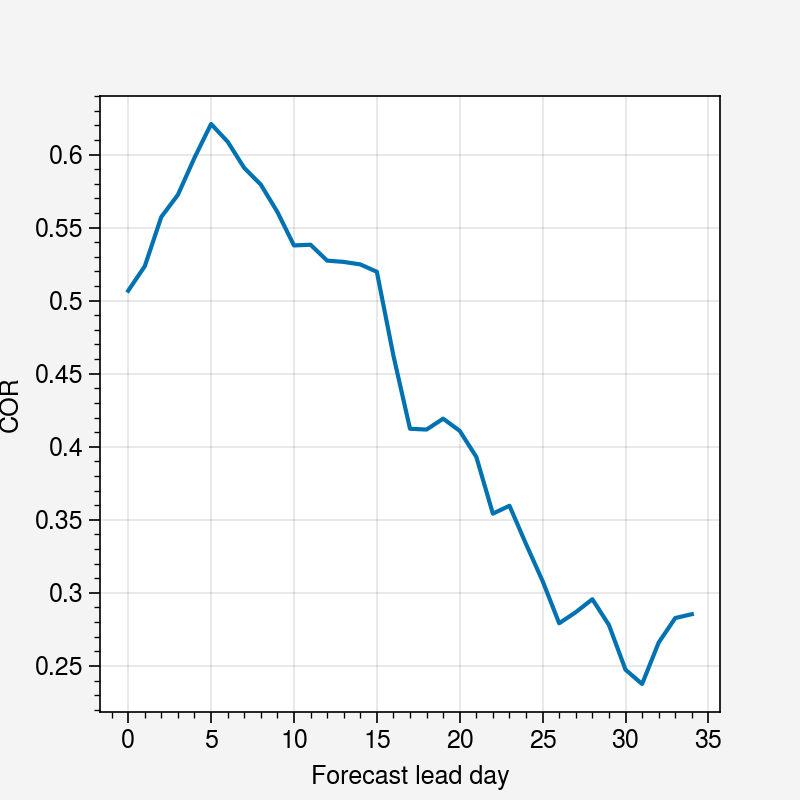

In [40]:
import matplotlib.pyplot as plt

plt.plot(cors)

plt.xlabel('Forecast lead day')
plt.ylabel('COR')


plt.show()


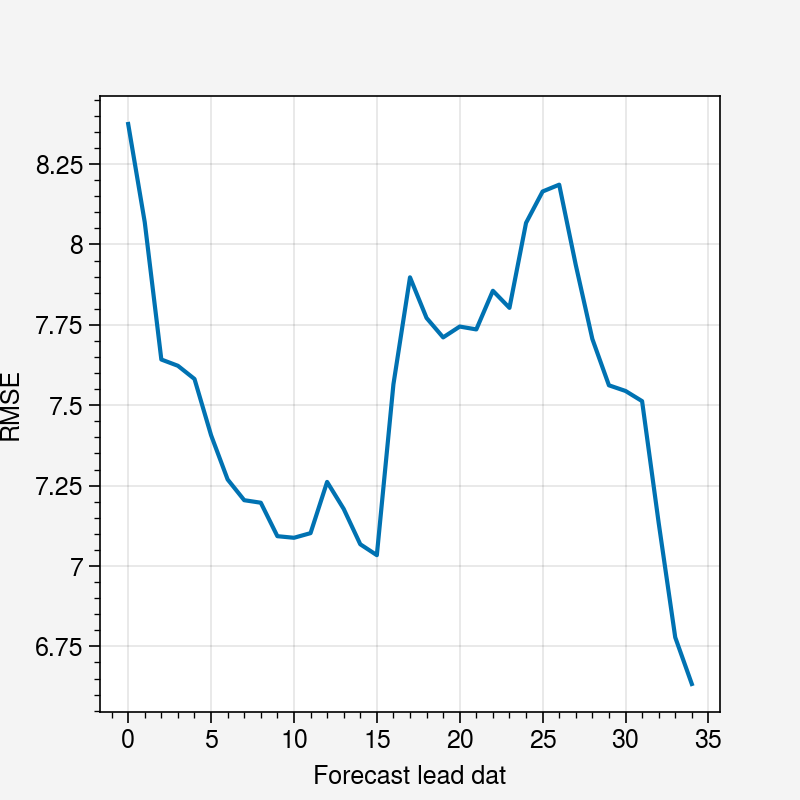

In [41]:
import matplotlib.pyplot as plt

plt.plot(rmses)

plt.xlabel('Forecast lead dat')
plt.ylabel('RMSE')


plt.show()

In [ ]:
##Testing function
def generate_end_dates(start_dates, forecast_hour):
    end_dates = []
    for start_date in start_dates:
        end_date = start_date + timedelta(days=(forecast_hour-1))
        if (end_date - start_date).days != (forecast_hour - 1):
            end_date += timedelta(days=1)
        end_dates.append(end_date)
    return end_dates

generate_end_dates([datetime(2012, 2, 1),datetime(2024, 2, 2)],35)

In [ ]:
##duplicates testing

file=np.sort(glob.glob('/projects/cstan/ufs5/daily/mean/u200/'+'*.nc'))
files=[f for f in file if str(1)+'.nc' in f]
data_u200=xr.open_mfdataset(files,combine='nested',concat_dim='time',parallel=True)
x=data_u200.sel(time='2011-05-01')['u200'][0,:,:]
y=data_u200.sel(time='2011-05-01')['u200'][1,:,:]

In [ ]:
##NOT needed but can be used to find the end date from start date (non-leap calendar)

def generate_end_dates(start_dates, forecast_hour):
    end_dates = []
    for start_date in start_dates:
        end_date = start_date + timedelta(days=(forecast_hour-1))
        if (end_date - start_date).days != (forecast_hour - 1):
            end_date += timedelta(days=1)
        end_dates.append(end_date)
    return end_dates